# Recurrent Neural Network to generate (predict) text data using Keras
* LSTM (Long Short-Term Memory) Network
* Code based on this article https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
* Data: full text of Alice in Wonderland taken from https://archive.org/stream/alicesadventures19033gut/19033.txt

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# SOURCE: https://archive.org/stream/alicesadventures19033gut/19033.txt
text = open('Alice_in_Wonderland.txt').read()
text = text.replace('.', ' .')
#text = text.replace(',', ' ,')
text = text.replace('\n', ' ')
#print(text[:5000])
text = text.split(' ')
#print(text[500:550])

# Use Tokenizer class to turn text into numeric data

In [3]:
# set num_words to some int value to reduce size of label array, and number of params in last layer of model
tokenizer = Tokenizer(num_words=None, char_level=False, split=' ', filters=',!"#$%&()*+-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
# for some reason, tokenizer returns sequences
flat_seq = []
for sub_arr in sequences:
    for item in sub_arr:
        flat_seq.append(item)
seq = np.array(flat_seq, dtype=np.int32)
print(seq)
print(len(seq), 'total words')

[ 11   9 338 ...  20 151   2]
10124 total words


In [4]:
print(len(tokenizer.index_word), ' words in the dictionary') # number of unique words
print([tokenizer.index_word[i] for i in range(1,10)]) # first ten words in dictionary (indexing starts at 1)

1524  words in the dictionary
['the', '.', 'and', 'a', 'to', 'she', 'of', 'it', 'was']


# Prepare training data and labels
* Features (model input): 50 consecutive words from the text
* Labels (model output): The next word in that sequence

In [5]:
features = []
labels = []

training_len = 50

for i in range(training_len, len(seq)):
    # sub_seq has length of trainin_len + 1
    sub_seq = seq[i-training_len : i+1]
    features.append(sub_seq[:-1]) # all but last word
    labels.append(sub_seq[-1]) # last word in sub-sequence

# hold on to sorted data/labels for text generation after we train the model
X_sorted, y_sorted = np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)
# use shuffled data for training and testing
X,y = shuffle(X_sorted, y_sorted)

print(X.shape, y.shape)
print(X[0], y[0])

print([tokenizer.index_word[i] for i in X[0]], 
      tokenizer.index_word[y[0]])

(10074, 50) (10074,)
[7.430e+02 4.000e+01 4.000e+00 2.830e+02 8.000e+00 1.247e+03 4.000e+00
 1.690e+02 3.110e+02 5.000e+00 4.600e+01 1.200e+01 1.100e+01 2.090e+02
 2.800e+01 7.900e+01 3.100e+01 1.370e+02 2.700e+01 5.190e+02 1.700e+01
 8.000e+00 4.440e+02 3.000e+00 5.600e+01 1.300e+01 9.000e+00 1.300e+01
 1.248e+03 5.160e+02 1.249e+03 1.300e+01 1.110e+02 4.200e+01 4.800e+01
 1.250e+03 2.000e+00 6.400e+01 3.500e+01 4.700e+01 4.100e+01 1.200e+01
 1.000e+00 2.420e+02 1.000e+01 4.000e+00 1.251e+03 1.580e+02 1.700e+01
 8.000e+00] 520.0
['girl', 'or', 'a', 'serpent', 'it', 'matters', 'a', 'good', 'deal', 'to', 'me', 'said', 'alice', 'hastily', 'but', "i'm", 'not', 'looking', 'for', 'eggs', 'as', 'it', 'happens', 'and', 'if', 'i', 'was', 'i', "shouldn't", 'want', 'yours', 'i', "don't", 'like', 'them', 'raw', '.', 'well', 'be', 'off', 'then', 'said', 'the', 'pigeon', 'in', 'a', 'sulky', 'tone', 'as', 'it'] settled


# One-Hot encoding of labels, Train/Test split
* One-hot scheme: 3 == [0 0 0 1 0 ... 0] 
* Binary array represents class probabilities (each unique word is a class)
* NOTE: the one-hot encoding will take up significantly more memory than the integer representation of labels. To reduce the size of the encoded labels, set the `num_words` parameter in the Tokenizer object. This will also reduce the number of parameters in the final layer

In [6]:
# + 1 because word dictionary indexing starts at 1
n_words = len(tokenizer.index_word) + 1

# one-hot encoding for labels
y_onehot = to_categorical(y, n_words)
#print(list(y_onehot[0]).index(1), y[0]) # these two should be the same int value
#print(y_onehot.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8059, 50) (8059, 1525)
(2015, 50) (2015, 1525)


# Handling label imbalance by creating a dictionary of class weights
* The most common words are much more common than the vast majority of less common. This leads to a network which is heavily biased towards those words, and only produces them
* To combat this, we can assign more weight during training to instances whose labels are less common (not when testing/predicting)
* Using keras, we can pass in a `class_weight` dictionary to the `fit()` method

In [7]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weights)

[0.01059333 0.01690597 0.01985056 ... 6.61023622 6.61023622 6.61023622]


# Create Model: LSTM (Long Short-Term Memory) Network
* Wikipedia: https://en.wikipedia.org/wiki/Long_short-term_memory
* Mathematical explanation of LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* LSTMs by example: https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

In [25]:
model = Sequential()

# https://keras.io/layers/embeddings/
# can reduce model complexity by pre-computing embedding matrix, setting trainable=False
model.add(Embedding(input_dim=n_words, input_length=training_len, output_dim=100,
                    trainable=True, mask_zero=True))

# https://keras.io/layers/core/#Masking
#model.add(Masking(mask_value=0.0))

# https://keras.io/layers/recurrent/
model.add(LSTM(512, return_sequences=False, dropout=0.5, recurrent_dropout=0.1))

# fully-connected layer with dropout
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# output layer - softmax activation for predicted class probabilities
model.add(Dense(n_words, activation='softmax'))


# Compile the model. Same loss function as with MNIST model (multi-class classification score)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           152500    
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1525)              1563125   
Total params: 3,496,361
Trainable params: 3,496,361
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
cb = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)]

with tf.device('/gpu:0'):
    hist = model.fit(X_train, y_train, batch_size=128, epochs=30, 
                     class_weight=class_weights, validation_split=0.2,
                     callbacks=[])

Train on 6447 samples, validate on 1612 samples
Epoch 1/30
6447/6447 [==============================] - 6s 1ms/sample - loss: 6.2585 - accuracy: 0.0552 - val_loss: 5.9108 - val_accuracy: 0.0658
Epoch 2/30
6447/6447 [==============================] - 4s 609us/sample - loss: 5.8655 - accuracy: 0.0565 - val_loss: 5.9219 - val_accuracy: 0.0658
Epoch 3/30
6447/6447 [==============================] - 4s 590us/sample - loss: 5.7816 - accuracy: 0.0574 - val_loss: 5.8642 - val_accuracy: 0.0658
Epoch 4/30
6447/6447 [==============================] - 4s 666us/sample - loss: 5.6826 - accuracy: 0.0614 - val_loss: 5.8624 - val_accuracy: 0.0664
Epoch 5/30
6447/6447 [==============================] - 4s 575us/sample - loss: 5.6271 - accuracy: 0.0611 - val_loss: 5.8684 - val_accuracy: 0.0645
Epoch 6/30
6447/6447 [==============================] - 4s 576us/sample - loss: 5.5785 - accuracy: 0.0631 - val_loss: 5.8951 - val_accuracy: 0.0676
Epoch 7/30
6447/6447 [==============================] - 4s 576us/s

In [27]:
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=0) 
# bugged output? Displays way too many '=' in progress bar when verbose=1
print(scores)

[8.391769155970874, 0.0898263]


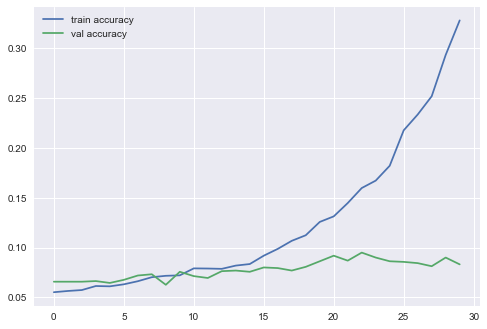

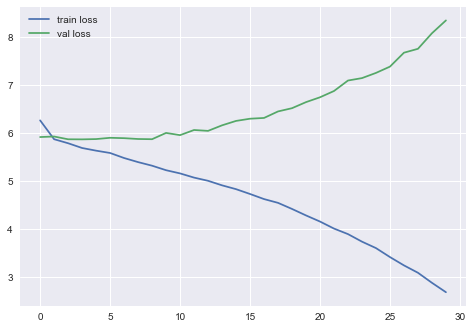

In [28]:
plt.style.use('seaborn')

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.show()

# Use trained model to predict next word

In [49]:
rand_ind = np.random.randint(len(X_sorted)-training_len)
#rand_ind = 0 # uncomment to specify a start index

seed_seq = X_sorted[rand_ind]
# np.argmax() to go from binary label arrays to integer class labels
actual_seq = y_sorted[rand_ind : rand_ind+training_len]

pred_seq = np.empty((training_len,))
for i in range(training_len):
    pred_seq[i] = np.argmax(model.predict(np.expand_dims(X_sorted[rand_ind+i, :], axis=0))[0])
    

print('Seed Sequence: ')
print('\"' + ' '.join([tokenizer.index_word[i] for i in seed_seq]) + '\"')
print('\nPredicted next 50 words: ')
print('\"' + ' '.join([tokenizer.index_word[i] for i in pred_seq]) + '\"')
print('\nActual next 50 words: ')
print('\"' + ' '.join([tokenizer.index_word[i] for i in actual_seq]) + '\"')


Seed Sequence: 
"bill the master says you've got to go down the chimney alice drew her foot as far down the chimney as she could and waited till she heard a little animal scratching and scrambling about in the chimney close above her then she gave one sharp kick and waited to"

Predicted next 50 words: 
"have it i you knee of the duchess thing was was to she general passion of seven goes one about custard rabbit's roast alone catch him you be you whole and silence and then another confusion on way or of his head brandy consider don't choke him yes happened to"

Actual next 50 words: 
"see what would happen next . the first thing she heard was a general chorus of there goes bill then the rabbit's voice alone catch him you by the hedge then silence and then another confusion of voices hold up his head brandy now don't choke him what happened to"


# Conclusion: NLP is hard :(